##### Import

In [1]:
import warnings
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from utils import rank_stocks_and_quantile

top = 250 # parameters -> papermill

DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_key = '/data/YEAR_20200929_20220902'
# dataset_key = None

with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # dataset = store['/data/YEAR_20161115_20181022']
    dataset = rank_stocks_and_quantile(dataset, TARGET_col='TARGET_ret_fwd_frac_order')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 123322 entries, (Timestamp('2020-09-29 00:00:00+0000', tz='UTC'), 'AA') to (Timestamp('2022-09-02 00:00:00+0000', tz='UTC'), 'ZTS')
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_rank_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 295.1+ MB


In [4]:
# Define the features and label columns
features = [col for col in dataset.columns if col.startswith('FEATURE_')]
label = 'TARGET_ret_fwd_frac_order_rank_quantiled'

# Print the number of features and the label
print(f"Number of features: {len(features)}")
print(f"Label: {label}")

# Remove timezone information from the date index
dataset.index.set_levels(dataset.index.levels[0].tz_localize(None), level=0, inplace=True)

# Get unique dates and sort them
unique_dates = dataset.index.get_level_values('date').unique().sort_values()

# Define the look-ahead gap
look_ahead = 1

# Split dates for training and testing with a gap
train_dates = unique_dates[:-21-look_ahead]
test_dates = unique_dates[-21:]

# Split the dataset using the train and test dates
train_data = dataset[dataset.index.get_level_values('date').isin(train_dates)]
test_data = dataset[dataset.index.get_level_values('date').isin(test_dates)]


Number of features: 586
Label: TARGET_ret_fwd_frac_order_rank_quantiled


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5313 entries, (Timestamp('2022-08-05 00:00:00'), 'AA') to (Timestamp('2022-09-02 00:00:00'), 'ZTS')
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_rank_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 12.7+ MB


In [6]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                index=model.feature_name()))
                
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], \
        is_higher_better

def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm that calculates daily Spearman correlations."""
    labels = train_data.get_label()
    # print(type(preds))
    # print(type(train_data))
    # print(labels)
    # Assuming the data index is a MultiIndex with date as the first level
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    # Group by the first level of the MultiIndex (date) and compute the Spearman correlation for each group
    grouped_labels = pd.Series(labels, \
        index=train_data.data.index).groupby(level=0)
    # print(len(grouped_labels))
    grouped_preds = pd.Series(preds, \
        index=train_data.data.index).groupby(level=0)
    # print(len(grouped_preds))

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        if np.isnan(score_for_day):
            score_for_day = 0
        daily_scores.append(score_for_day)

    # Calculate the Sharpe ratio
    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)  
    # added epsilon to avoid division by zero

    return 'sharpe_ratio', sharpe_ratio, True


def custom_eval_metrics(preds, train_data):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    labels = train_data.get_label()
    mae = mean_absolute_error(labels, preds)
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(labels, preds)

    return [("MAE", mae, False), 
            ("MSE", mse, False), 
            ("RMSE", rmse, False), 
            ("R2", r2, True)]

In [7]:
def metrics_on_fold(era_scores):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    # Cleanup
    _ = gc.collect()
    
    return metrics

In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
from utils import CustomBackwardMultipleTimeSeriesCV
import warnings

warnings.filterwarnings('ignore')

evals_result = {}

def get_categoricals(dataset, threshold):
    return [col for col in dataset.columns if \
            dataset[col].nunique() < threshold and \
            dataset[col].ge(0).all() and col.startswith("FEATURE_")]

def objective(trial, data, features, cv):
    # Dynamic categoricals based on the trial's suggested threshold
    cat_threshold = trial.suggest_int('cat_threshold', 5, 50)
    categoricals = [col for col in data.columns if data[col].nunique() < cat_threshold 
                    and data[col].ge(0).all() and col.startswith("FEATURE_")]

    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    early_stopping = lgb.early_stopping(stopping_rounds=500, \
        verbose=True, first_metric_only=True)
    daily_scores_in_fold = []

    for train_idx, val_idx in cv:
        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]
        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                        categorical_feature=categoricals, free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]
        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                categorical_feature=categoricals, free_raw_data=False)

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=5000,
                          valid_sets=[lgb_train, lgb_val],
                          valid_names=['train', 'valid_0'],
                          feval=[sharpe_ratio_lgbm, custom_eval_metrics],
                          callbacks=[lgb.record_evaluation(evals_result),
                                     early_stopping,
                                     LightGBMPruningCallback(trial, 'sharpe_ratio')])
        
        daily_scores_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])

    metrics = metrics_on_fold(daily_scores_in_fold)
    score = metrics['sharpe_ratio']

    # Log parameters, metrics, and evaluation results to MLflow
    with mlflow.start_run():
        mlflow.log_params(params)
        
        # Log metrics from metrics dictionary
        mlflow.log_metrics(metrics)
        
        # Logging each score and metric in evals_result
        for valid_set, metrics_dict in evals_result.items():
            for metric, values in metrics_dict.items():
                for idx, value in enumerate(values):
                    metric_name = f"{valid_set}_{metric}_{idx}"
                    mlflow.log_metric(metric_name, value)

        # Log the average sharpe ratio
        mlflow.log_metric("avg_sharpe_ratio_across_folds", np.mean(score))

        # mlflow.lightgbm.log_model(model, "lightgbm_model")

    score = metrics['sharpe_ratio']
    return score if not np.isnan(score) else 1e-9

In [9]:
import os
import optuna

cv = CustomBackwardMultipleTimeSeriesCV(train_data, train_period_length=142, 
                                        test_period_length=5, 
                                        lookahead=1, 
                                        date_idx='date')

def progress_bar(study, trial, n_trials):
    progress = (trial.number + 1) / n_trials
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = f"Best is trial {study.best_trial.number} \
            with value: {study.best_trial.value}."
    print(f'Trial {trial.number + 1}/{n_trials} finished with value: \
        {trial.value} and parameters: {trial.params}. {best_trial_msg}')

# Check if 'study' directory exists, if not, create it.
if not os.path.exists("study"):
    os.makedirs("study")

# Use SQLite to store optimization results.
# The study results are stored in the "study" folder as "study.db".
storage_name = "sqlite:///study/study.db"

# Name of the study. This should be consistent for resuming the study later.
study_name = "lgbm_optimization"

# Try to load the study. If it doesn't exist, create a new one.
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='maximize',
                            load_if_exists=True, 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, \
                            n_warmup_steps=5))

n_trials = 15
study.optimize(lambda trial: objective(trial, train_data, features, cv), 
               n_trials=n_trials, 
               callbacks=[lambda study, trial: progress_bar(study, trial, n_trials)])

# Printing the optimization results
print(f'Best trial score: {study.best_trial.value}')
print('Best hyperparameters:')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

# Remove the study database
os.remove("study/study.db")
print("Database has been deleted.")

[I 2023-09-30 19:41:02,140] A new study created in RDB with name: lgbm_optimization


Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1]	train's sharpe_ratio: 16.9942	train's MAE: 0.296797	train's MSE: 0.12163	train's RMSE: 0.348755	train's R2: 0.0285393	valid_0's sharpe_ratio: 105.905	valid_0's MAE: 0.297252	valid_0's MSE: 0.121779	valid_0's RMSE: 0.348968	valid_0's R2: 0.0295914
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1]	train's sharpe_ratio: 101.75	train's MAE: 0.296039	train's MSE: 0.121063	train's RMSE: 0.347941	train's R2: 0.0327187	valid_0's sharpe_ratio: 469.053	valid_0's MAE: 0.29606	valid_0's MSE: 0.121094	valid_0's RMSE: 0.347985	valid_0's R2: 0.031219
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[131]	train's sharpe_ratio: 82.2173	train's MAE: 0.0735206	train's MSE: 0.00897663	train's RMSE: 0.0947451	train's R2: 0.928183	valid_0's sharpe_ratio:

[I 2023-09-30 19:42:40,684] Trial 0 finished with value: 1.1175945009427488 and parameters: {'cat_threshold': 13, 'num_leaves': 41, 'learning_rate': 0.01782199012583019, 'feature_fraction': 0.9122178287813881, 'bagging_fraction': 0.8023871786235478, 'bagging_freq': 7, 'min_child_samples': 97, 'lambda_l1': 0.00011361747653456042, 'lambda_l2': 3.096261145625358e-08}. Best is trial 0 with value: 1.1175945009427488.


Trial 1/15 finished with value:         1.1175945009427488 and parameters: {'cat_threshold': 13, 'num_leaves': 41, 'learning_rate': 0.01782199012583019, 'feature_fraction': 0.9122178287813881, 'bagging_fraction': 0.8023871786235478, 'bagging_freq': 7, 'min_child_samples': 97, 'lambda_l1': 0.00011361747653456042, 'lambda_l2': 3.096261145625358e-08}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:42:44,197] Trial 1 finished with value: 1e-09 and parameters: {'cat_threshold': 18, 'num_leaves': 84, 'learning_rate': 0.0020682662096210207, 'feature_fraction': 0.6453910709250378, 'bagging_fraction': 0.5411154437633809, 'bagging_freq': 5, 'min_child_samples': 45, 'lambda_l1': 0.00017731615510327927, 'lambda_l2': 5.2043409268556216e-08}. Best is trial 0 with value: 1.1175945009427488.


Trial 2/15 finished with value:         1e-09 and parameters: {'cat_threshold': 18, 'num_leaves': 84, 'learning_rate': 0.0020682662096210207, 'feature_fraction': 0.6453910709250378, 'bagging_fraction': 0.5411154437633809, 'bagging_freq': 5, 'min_child_samples': 45, 'lambda_l1': 0.00017731615510327927, 'lambda_l2': 5.2043409268556216e-08}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:42:47,595] Trial 2 finished with value: 1e-09 and parameters: {'cat_threshold': 46, 'num_leaves': 118, 'learning_rate': 0.0012481730433716671, 'feature_fraction': 0.5453115791907203, 'bagging_fraction': 0.8585358166099915, 'bagging_freq': 1, 'min_child_samples': 61, 'lambda_l1': 2.572037322403113e-06, 'lambda_l2': 7.653183587589983e-06}. Best is trial 0 with value: 1.1175945009427488.


Trial 3/15 finished with value:         1e-09 and parameters: {'cat_threshold': 46, 'num_leaves': 118, 'learning_rate': 0.0012481730433716671, 'feature_fraction': 0.5453115791907203, 'bagging_fraction': 0.8585358166099915, 'bagging_freq': 1, 'min_child_samples': 61, 'lambda_l1': 2.572037322403113e-06, 'lambda_l2': 7.653183587589983e-06}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:42:50,937] Trial 3 finished with value: 1e-09 and parameters: {'cat_threshold': 25, 'num_leaves': 62, 'learning_rate': 0.020080727544433224, 'feature_fraction': 0.9394515263944268, 'bagging_fraction': 0.704200702670992, 'bagging_freq': 6, 'min_child_samples': 80, 'lambda_l1': 0.00013264124245911577, 'lambda_l2': 1.0749011016686165}. Best is trial 0 with value: 1.1175945009427488.


Trial 4/15 finished with value:         1e-09 and parameters: {'cat_threshold': 25, 'num_leaves': 62, 'learning_rate': 0.020080727544433224, 'feature_fraction': 0.9394515263944268, 'bagging_fraction': 0.704200702670992, 'bagging_freq': 6, 'min_child_samples': 80, 'lambda_l1': 0.00013264124245911577, 'lambda_l2': 1.0749011016686165}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:42:54,289] Trial 4 finished with value: 1e-09 and parameters: {'cat_threshold': 11, 'num_leaves': 47, 'learning_rate': 0.0039387623646789886, 'feature_fraction': 0.7828045987494359, 'bagging_fraction': 0.44208620281401323, 'bagging_freq': 6, 'min_child_samples': 25, 'lambda_l1': 4.016314764513806e-08, 'lambda_l2': 0.0020849750216297013}. Best is trial 0 with value: 1.1175945009427488.


Trial 5/15 finished with value:         1e-09 and parameters: {'cat_threshold': 11, 'num_leaves': 47, 'learning_rate': 0.0039387623646789886, 'feature_fraction': 0.7828045987494359, 'bagging_fraction': 0.44208620281401323, 'bagging_freq': 6, 'min_child_samples': 25, 'lambda_l1': 4.016314764513806e-08, 'lambda_l2': 0.0020849750216297013}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:42:57,612] Trial 5 finished with value: 1e-09 and parameters: {'cat_threshold': 20, 'num_leaves': 101, 'learning_rate': 0.06166028447128955, 'feature_fraction': 0.7056422609258828, 'bagging_fraction': 0.8111162487836168, 'bagging_freq': 1, 'min_child_samples': 70, 'lambda_l1': 1.3716843435793498e-06, 'lambda_l2': 0.030865756848190234}. Best is trial 0 with value: 1.1175945009427488.


Trial 6/15 finished with value:         1e-09 and parameters: {'cat_threshold': 20, 'num_leaves': 101, 'learning_rate': 0.06166028447128955, 'feature_fraction': 0.7056422609258828, 'bagging_fraction': 0.8111162487836168, 'bagging_freq': 1, 'min_child_samples': 70, 'lambda_l1': 1.3716843435793498e-06, 'lambda_l2': 0.030865756848190234}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:00,962] Trial 6 finished with value: 1e-09 and parameters: {'cat_threshold': 34, 'num_leaves': 90, 'learning_rate': 0.03377004079573054, 'feature_fraction': 0.569106186036522, 'bagging_fraction': 0.845887503160843, 'bagging_freq': 4, 'min_child_samples': 71, 'lambda_l1': 1.679889298146136e-08, 'lambda_l2': 2.8031697684859993}. Best is trial 0 with value: 1.1175945009427488.


Trial 7/15 finished with value:         1e-09 and parameters: {'cat_threshold': 34, 'num_leaves': 90, 'learning_rate': 0.03377004079573054, 'feature_fraction': 0.569106186036522, 'bagging_fraction': 0.845887503160843, 'bagging_freq': 4, 'min_child_samples': 71, 'lambda_l1': 1.679889298146136e-08, 'lambda_l2': 2.8031697684859993}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:04,281] Trial 7 finished with value: 1e-09 and parameters: {'cat_threshold': 7, 'num_leaves': 102, 'learning_rate': 0.022052211813344075, 'feature_fraction': 0.6968924012815152, 'bagging_fraction': 0.5493339935848196, 'bagging_freq': 2, 'min_child_samples': 79, 'lambda_l1': 0.0028989505452915914, 'lambda_l2': 0.06205329843910742}. Best is trial 0 with value: 1.1175945009427488.


Trial 8/15 finished with value:         1e-09 and parameters: {'cat_threshold': 7, 'num_leaves': 102, 'learning_rate': 0.022052211813344075, 'feature_fraction': 0.6968924012815152, 'bagging_fraction': 0.5493339935848196, 'bagging_freq': 2, 'min_child_samples': 79, 'lambda_l1': 0.0028989505452915914, 'lambda_l2': 0.06205329843910742}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:07,646] Trial 8 finished with value: 1e-09 and parameters: {'cat_threshold': 19, 'num_leaves': 43, 'learning_rate': 0.035848914604783254, 'feature_fraction': 0.9948523229821515, 'bagging_fraction': 0.5566133875555699, 'bagging_freq': 2, 'min_child_samples': 30, 'lambda_l1': 1.4475010330771698e-07, 'lambda_l2': 0.005433183116909705}. Best is trial 0 with value: 1.1175945009427488.


Trial 9/15 finished with value:         1e-09 and parameters: {'cat_threshold': 19, 'num_leaves': 43, 'learning_rate': 0.035848914604783254, 'feature_fraction': 0.9948523229821515, 'bagging_fraction': 0.5566133875555699, 'bagging_freq': 2, 'min_child_samples': 30, 'lambda_l1': 1.4475010330771698e-07, 'lambda_l2': 0.005433183116909705}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:11,004] Trial 9 finished with value: 1e-09 and parameters: {'cat_threshold': 30, 'num_leaves': 35, 'learning_rate': 0.02214648746691684, 'feature_fraction': 0.42995904120676837, 'bagging_fraction': 0.7193858900798658, 'bagging_freq': 2, 'min_child_samples': 74, 'lambda_l1': 3.9746341731921225e-05, 'lambda_l2': 4.4275172760153975e-08}. Best is trial 0 with value: 1.1175945009427488.


Trial 10/15 finished with value:         1e-09 and parameters: {'cat_threshold': 30, 'num_leaves': 35, 'learning_rate': 0.02214648746691684, 'feature_fraction': 0.42995904120676837, 'bagging_fraction': 0.7193858900798658, 'bagging_freq': 2, 'min_child_samples': 74, 'lambda_l1': 3.9746341731921225e-05, 'lambda_l2': 4.4275172760153975e-08}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:14,384] Trial 10 finished with value: 1e-09 and parameters: {'cat_threshold': 39, 'num_leaves': 145, 'learning_rate': 0.008046963048410054, 'feature_fraction': 0.8619313493984542, 'bagging_fraction': 0.9850792753483462, 'bagging_freq': 7, 'min_child_samples': 100, 'lambda_l1': 0.543281599801454, 'lambda_l2': 4.770898724301792e-05}. Best is trial 0 with value: 1.1175945009427488.


Trial 11/15 finished with value:         1e-09 and parameters: {'cat_threshold': 39, 'num_leaves': 145, 'learning_rate': 0.008046963048410054, 'feature_fraction': 0.8619313493984542, 'bagging_fraction': 0.9850792753483462, 'bagging_freq': 7, 'min_child_samples': 100, 'lambda_l1': 0.543281599801454, 'lambda_l2': 4.770898724301792e-05}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:17,763] Trial 11 finished with value: 1e-09 and parameters: {'cat_threshold': 15, 'num_leaves': 61, 'learning_rate': 0.006116332112281237, 'feature_fraction': 0.851635770132274, 'bagging_fraction': 0.6093904662379885, 'bagging_freq': 5, 'min_child_samples': 44, 'lambda_l1': 0.0025846794765065103, 'lambda_l2': 1.2310400286985528e-08}. Best is trial 0 with value: 1.1175945009427488.


Trial 12/15 finished with value:         1e-09 and parameters: {'cat_threshold': 15, 'num_leaves': 61, 'learning_rate': 0.006116332112281237, 'feature_fraction': 0.851635770132274, 'bagging_fraction': 0.6093904662379885, 'bagging_freq': 5, 'min_child_samples': 44, 'lambda_l1': 0.0025846794765065103, 'lambda_l2': 1.2310400286985528e-08}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:21,181] Trial 12 finished with value: 1e-09 and parameters: {'cat_threshold': 8, 'num_leaves': 72, 'learning_rate': 0.002653012390213721, 'feature_fraction': 0.6959247890102255, 'bagging_fraction': 0.42552795279658584, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.002349915309257546, 'lambda_l2': 5.234861179977504e-07}. Best is trial 0 with value: 1.1175945009427488.


Trial 13/15 finished with value:         1e-09 and parameters: {'cat_threshold': 8, 'num_leaves': 72, 'learning_rate': 0.002653012390213721, 'feature_fraction': 0.6959247890102255, 'bagging_fraction': 0.42552795279658584, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.002349915309257546, 'lambda_l2': 5.234861179977504e-07}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:24,508] Trial 13 finished with value: 1e-09 and parameters: {'cat_threshold': 23, 'num_leaves': 131, 'learning_rate': 0.010288192069017451, 'feature_fraction': 0.9174865401737174, 'bagging_fraction': 0.6116792684196812, 'bagging_freq': 7, 'min_child_samples': 44, 'lambda_l1': 2.3988226463475954e-05, 'lambda_l2': 4.811147189456668e-07}. Best is trial 0 with value: 1.1175945009427488.


Trial 14/15 finished with value:         1e-09 and parameters: {'cat_threshold': 23, 'num_leaves': 131, 'learning_rate': 0.010288192069017451, 'feature_fraction': 0.9174865401737174, 'bagging_fraction': 0.6116792684196812, 'bagging_freq': 7, 'min_child_samples': 44, 'lambda_l1': 2.3988226463475954e-05, 'lambda_l2': 4.811147189456668e-07}. Best is trial 0             with value: 1.1175945009427488.


[I 2023-09-30 19:43:27,909] Trial 14 finished with value: 1e-09 and parameters: {'cat_threshold': 15, 'num_leaves': 74, 'learning_rate': 0.0015598183376759984, 'feature_fraction': 0.7981942133615534, 'bagging_fraction': 0.742543257500354, 'bagging_freq': 5, 'min_child_samples': 95, 'lambda_l1': 0.055004528718524265, 'lambda_l2': 1.4429594281780266e-08}. Best is trial 0 with value: 1.1175945009427488.


Trial 15/15 finished with value:         1e-09 and parameters: {'cat_threshold': 15, 'num_leaves': 74, 'learning_rate': 0.0015598183376759984, 'feature_fraction': 0.7981942133615534, 'bagging_fraction': 0.742543257500354, 'bagging_freq': 5, 'min_child_samples': 95, 'lambda_l1': 0.055004528718524265, 'lambda_l2': 1.4429594281780266e-08}. Best is trial 0             with value: 1.1175945009427488.
Best trial score: 1.1175945009427488
Best hyperparameters:
cat_threshold: 13
num_leaves: 41
learning_rate: 0.01782199012583019
feature_fraction: 0.9122178287813881
bagging_fraction: 0.8023871786235478
bagging_freq: 7
min_child_samples: 97
lambda_l1: 0.00011361747653456042
lambda_l2: 3.096261145625358e-08
Best parameters found by Optuna:
{'cat_threshold': 13, 'num_leaves': 41, 'learning_rate': 0.01782199012583019, 'feature_fraction': 0.9122178287813881, 'bagging_fraction': 0.8023871786235478, 'bagging_freq': 7, 'min_child_samples': 97, 'lambda_l1': 0.00011361747653456042, 'lambda_l2': 3.09626114

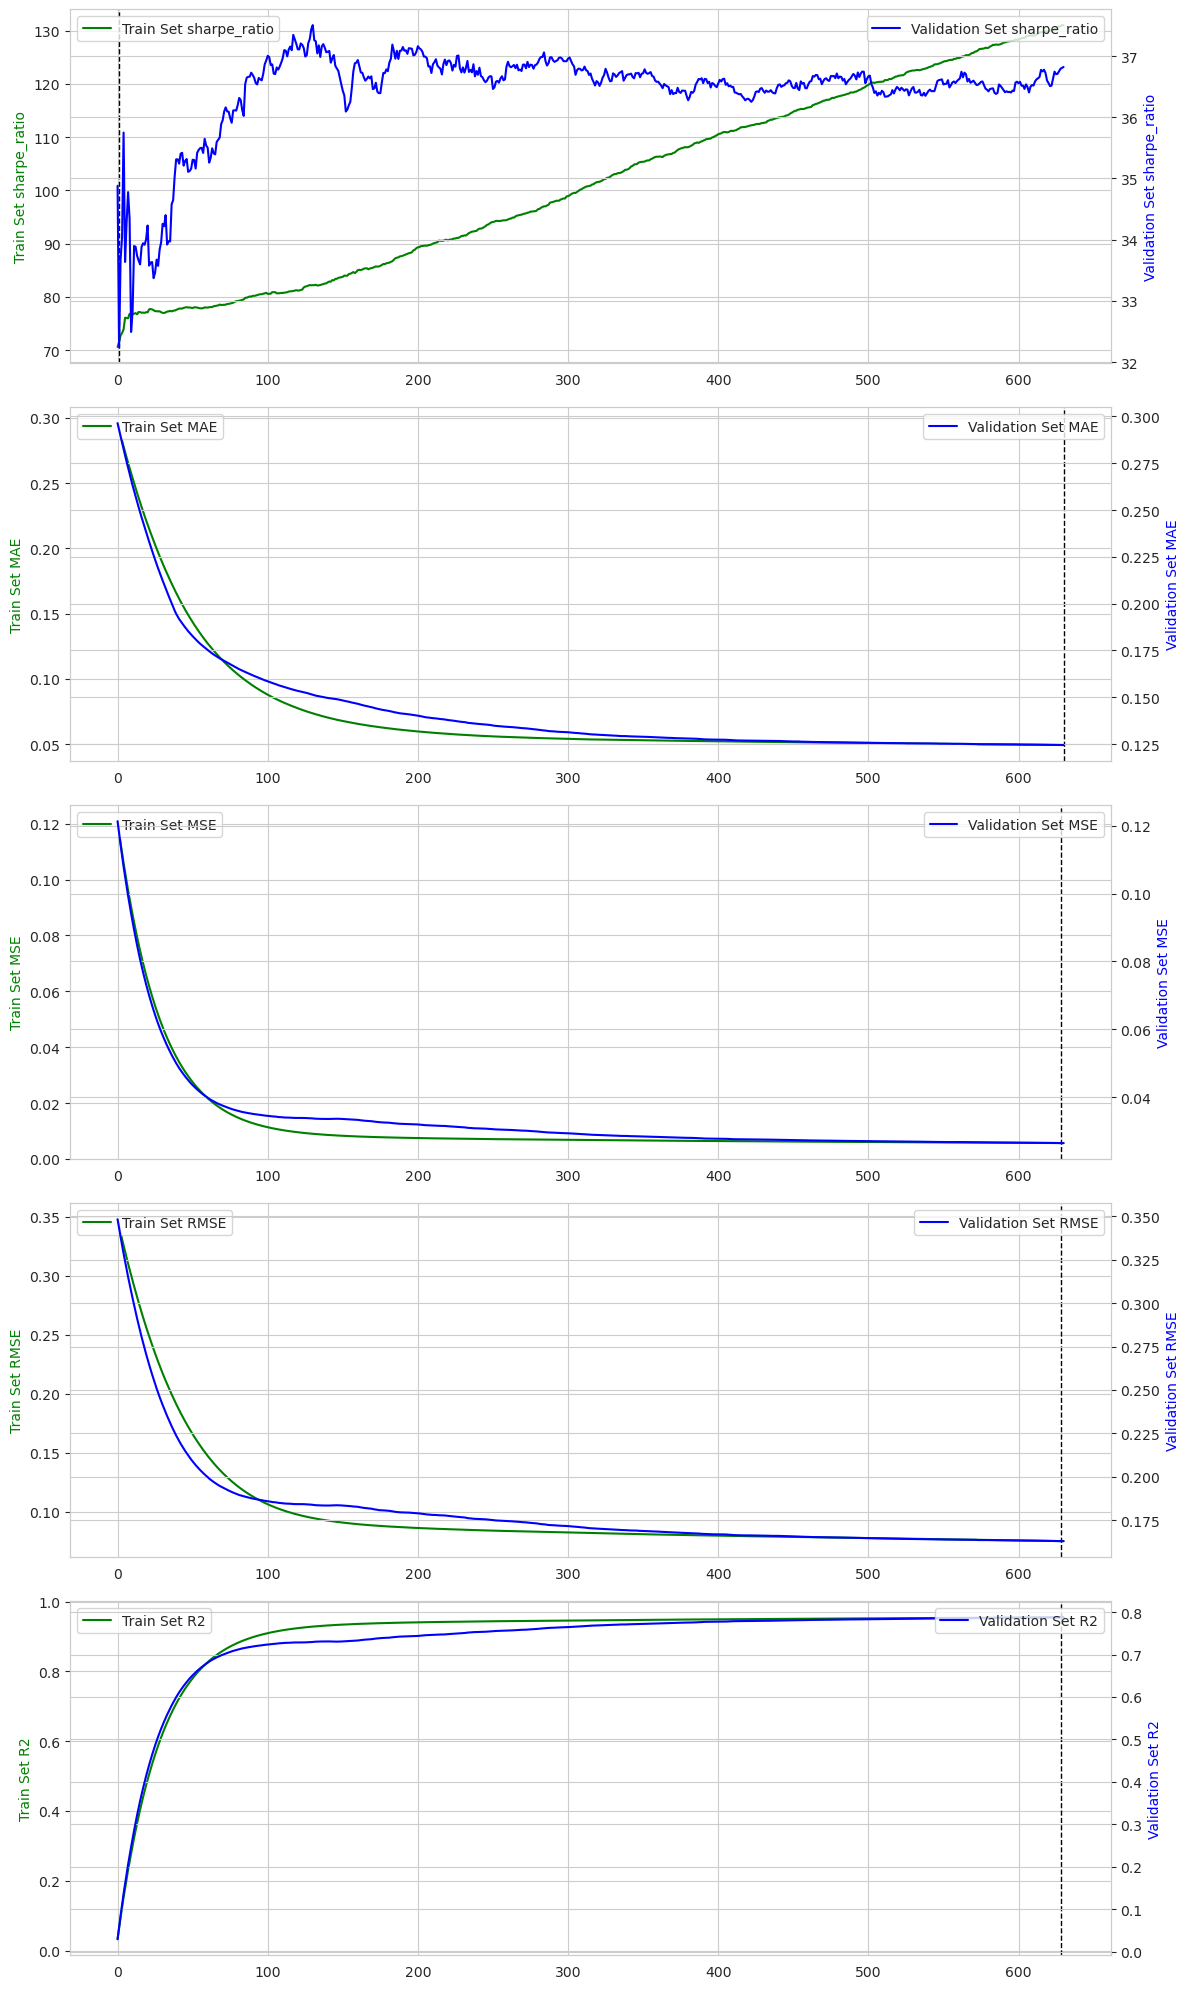

In [10]:
# Assuming evals_result contains MAE, MSE, RMSE, R2 as well
metrics = ['sharpe_ratio', 'MAE', 'MSE', 'RMSE', 'R2']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))

for ax, metric in zip(axes, metrics):
    cv_result = pd.DataFrame({'Train Set': evals_result['train'][metric], 
                              'Validation Set': evals_result['valid_0'][metric]})
    
    ax1 = ax
    ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
    
    ax1.plot(cv_result.index, cv_result['Train Set'], 'g-', label=f'Train Set {metric}')
    ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-', label=f'Validation Set {metric}')
    
    ax1.set_ylabel(f'Train Set {metric}', color='g')
    ax2.set_ylabel(f'Validation Set {metric}', color='b')
    
    if metric != 'R2':
        ax1.axvline(cv_result['Validation Set'].idxmin(), c='k', ls='--', lw=1)
    else:
        ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [11]:
# import matplotlib.pyplot as plt

# # Create DataFrame from results
# cv_result = pd.DataFrame({'Train Set': evals_result['train']['sharpe_ratio'], 
#                           'Validation Set': evals_result['valid_0']['sharpe_ratio']})

# # Create the plot with separate y-axes for Train and Validation sets
# fig, ax1 = plt.subplots(figsize=(12, 4))

# ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
# ax1.plot(cv_result.index, cv_result['Train Set'], 'g-')
# ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-')

# ax1.set_ylabel('Train Set', color='g')
# ax2.set_ylabel('Validation Set', color='b')
# ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

# plt.show()

In [12]:
# # Extract cat_threshold from best_params
# cat_threshold = best_params.get('cat_threshold', 50)  # default to 50 if not in best_params

# Extract cat_threshold from best_params
cat_threshold = best_params.pop('cat_threshold', 50)  # default to 50 if not in best_params


# Determine the categorical columns based on cat_threshold
categoricals = [col for col in train_data.columns if train_data[col].nunique() < cat_threshold 
                and train_data[col].ge(0).all() and col.startswith("FEATURE_")]

# Create the training dataset
lgb_train_all = lgb.Dataset(data=train_data[features], label=train_data[label], 
                            categorical_feature=categoricals, free_raw_data=False)

best_params['force_col_wise'] = True
# Train the model with the best parameters
# best_model = lgb.train(params=best_params,
#                        train_set=lgb_train_all,
#                        num_boost_round=5000,  # or some other number of boosting rounds
#                        feval=sharpe_ratio_lgbm,
#                        callbacks=[lgb.record_evaluation(evals_result)])
best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=5000,  # or some other number of boosting rounds
                       feval=sharpe_ratio_lgbm,
                       callbacks=[lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Total Bins 96003
[LightGBM] [Info] Number of data points in the train set: 117756, number of used features: 538
[LightGBM] [Info] Start training from score 0.501503


In [13]:
from pathlib import Path

# Define the models folder path
models = Path("./models")

# Ensure the folder exists
models.mkdir(exist_ok=True)

# Ensure that dataset_key doesn't contain invalid characters like slashes
clean_dataset_key = dataset_key.replace("/", "_")

# Formulate the clean save path
save_path = models / f"{clean_dataset_key}_best_model.txt"

# Try saving again
best_model.save_model(save_path)
print(f"Model saved to {save_path}")

Model saved to models/_data_YEAR_20200929_20220902_best_model.txt


#### Test on unseen data

In [14]:
test_features = test_data[features]
test_labels = test_data[label]

model_path = "/home/sayem/Desktop/Project/models/_data_YEAR_20200929_20220902_best_model.txt"
# Load the model
best_model = lgb.Booster(model_file=model_path)

y_pred = best_model.predict(test_features)

preds = test_labels.reset_index(name=\
    'actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

# Rename columns to add 'feature_' prefix
cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
new_col_names = ["FEATURE_" + col for col in cols_to_rename]
rename_dict = dict(zip(cols_to_rename, new_col_names))

test_data_renamed = test_data.rename(columns=rename_dict)

# Using the 'merge' method to join on MultiIndex levels 'date' and 'ticker'
preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                  on=['ticker', 'date'], 
                                  how='left')

### Only select columns of interest
preds = preds[['date', 'ticker', 'actual', 'predicted'] \
    + new_col_names].set_index(['ticker', 'date'])


In [15]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5439 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2022-09-02 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          5439 non-null   float64
 1   predicted       5439 non-null   float64
 2   FEATURE_open    5439 non-null   float32
 3   FEATURE_high    5439 non-null   float32
 4   FEATURE_low     5439 non-null   float32
 5   FEATURE_close   5439 non-null   float32
 6   FEATURE_volume  5439 non-null   float64
dtypes: float32(4), float64(3)
memory usage: 239.3+ KB


Dropped 71.4% entries from factor data: 47.6% in forward returns computation and 23.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!

Sharpe Ratios:
 1D     0.592281
5D    -0.895710
10D   -0.985662
dtype: float64
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,0.00,0.00,0.00000,0.000000,300,20.000000
2.0,0.25,0.25,0.25000,0.000000,300,20.000000
3.0,0.50,0.75,0.56375,0.109102,400,26.666667
4.0,0.75,0.75,0.75000,0.000000,200,13.333333
5.0,1.00,1.00,1.00000,0.000000,300,20.000000


Returns Analysis


,1D,5D,10D
Ann. alpha,0.206,-0.082,-0.091
beta,-0.182,0.038,0.018
Mean Period Wise Return Top Quantile (bps),7.702,-12.176,-10.279
Mean Period Wise Return Bottom Quantile (bps),-33.564,1.238,2.141
Mean Period Wise Spread (bps),41.265,-13.415,-12.418


<Figure size 640x480 with 0 Axes>

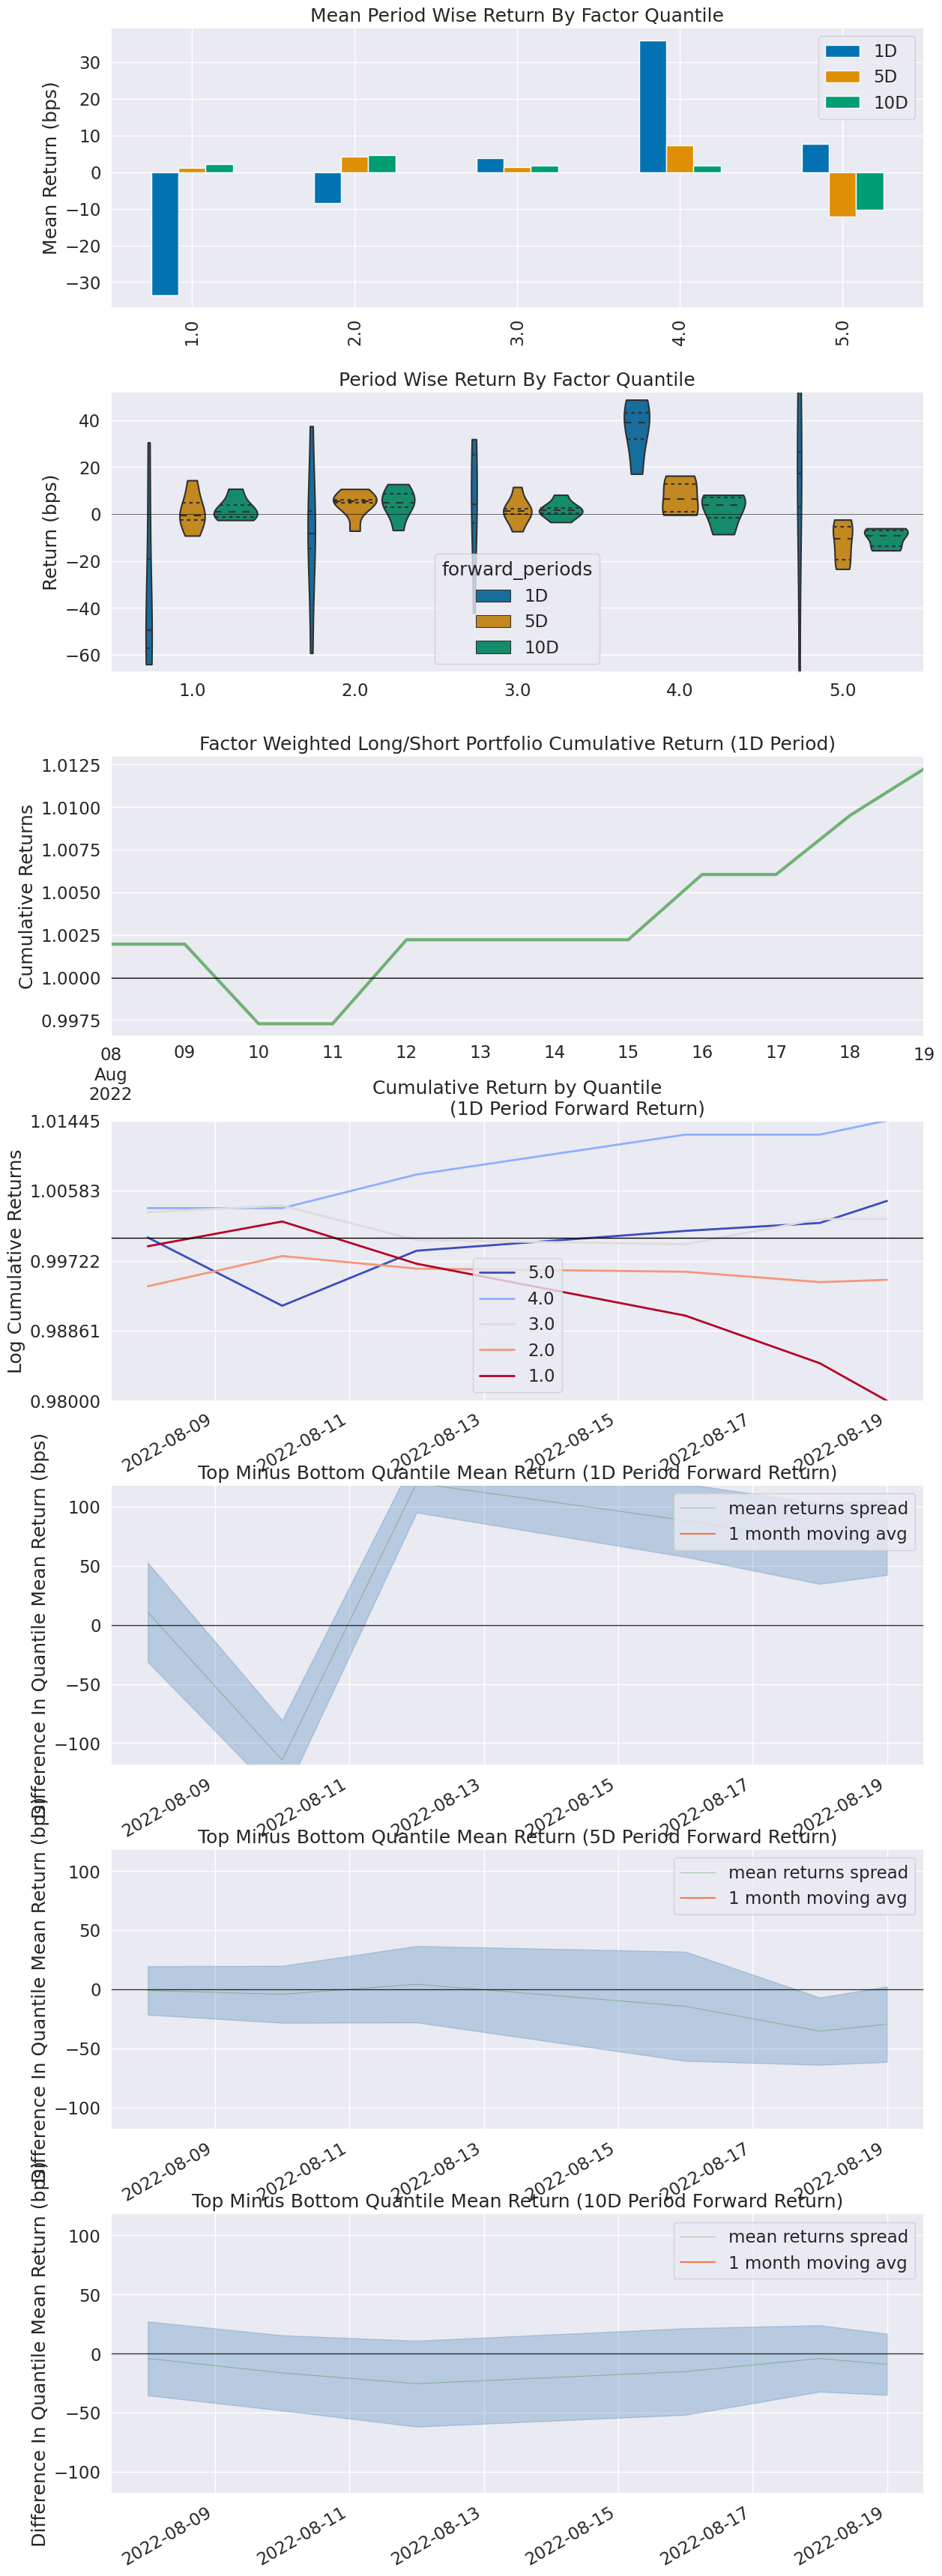

Information Analysis


,1D,5D,10D
IC Mean,0.111,-0.032,-0.075
IC Std.,0.197,0.044,0.071
Risk-Adjusted IC,0.562,-0.744,-1.056
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


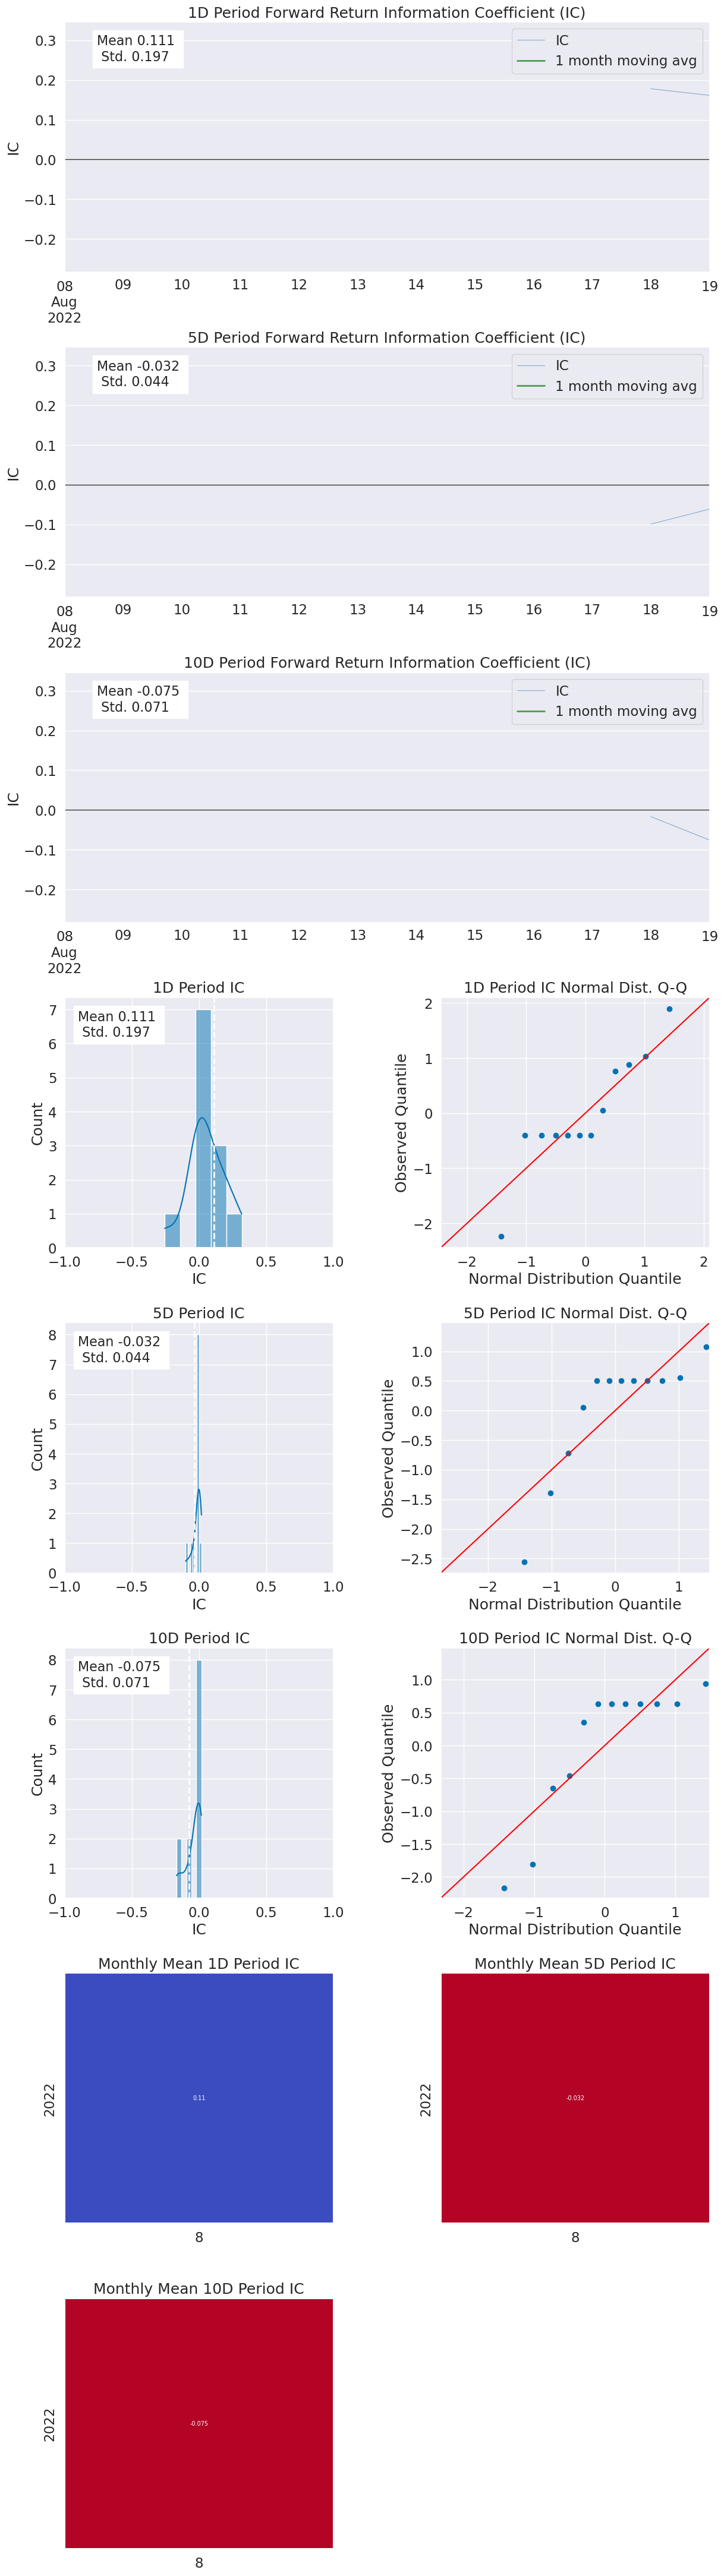

Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.12,NaN,0.12
Quantile 2.0 Mean Turnover,0.24,NaN,0.34
Quantile 3.0 Mean Turnover,0.14,NaN,0.62
Quantile 4.0 Mean Turnover,NaN,NaN,NaN
Quantile 5.0 Mean Turnover,0.10,NaN,0.06


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.951,NaN,0.941


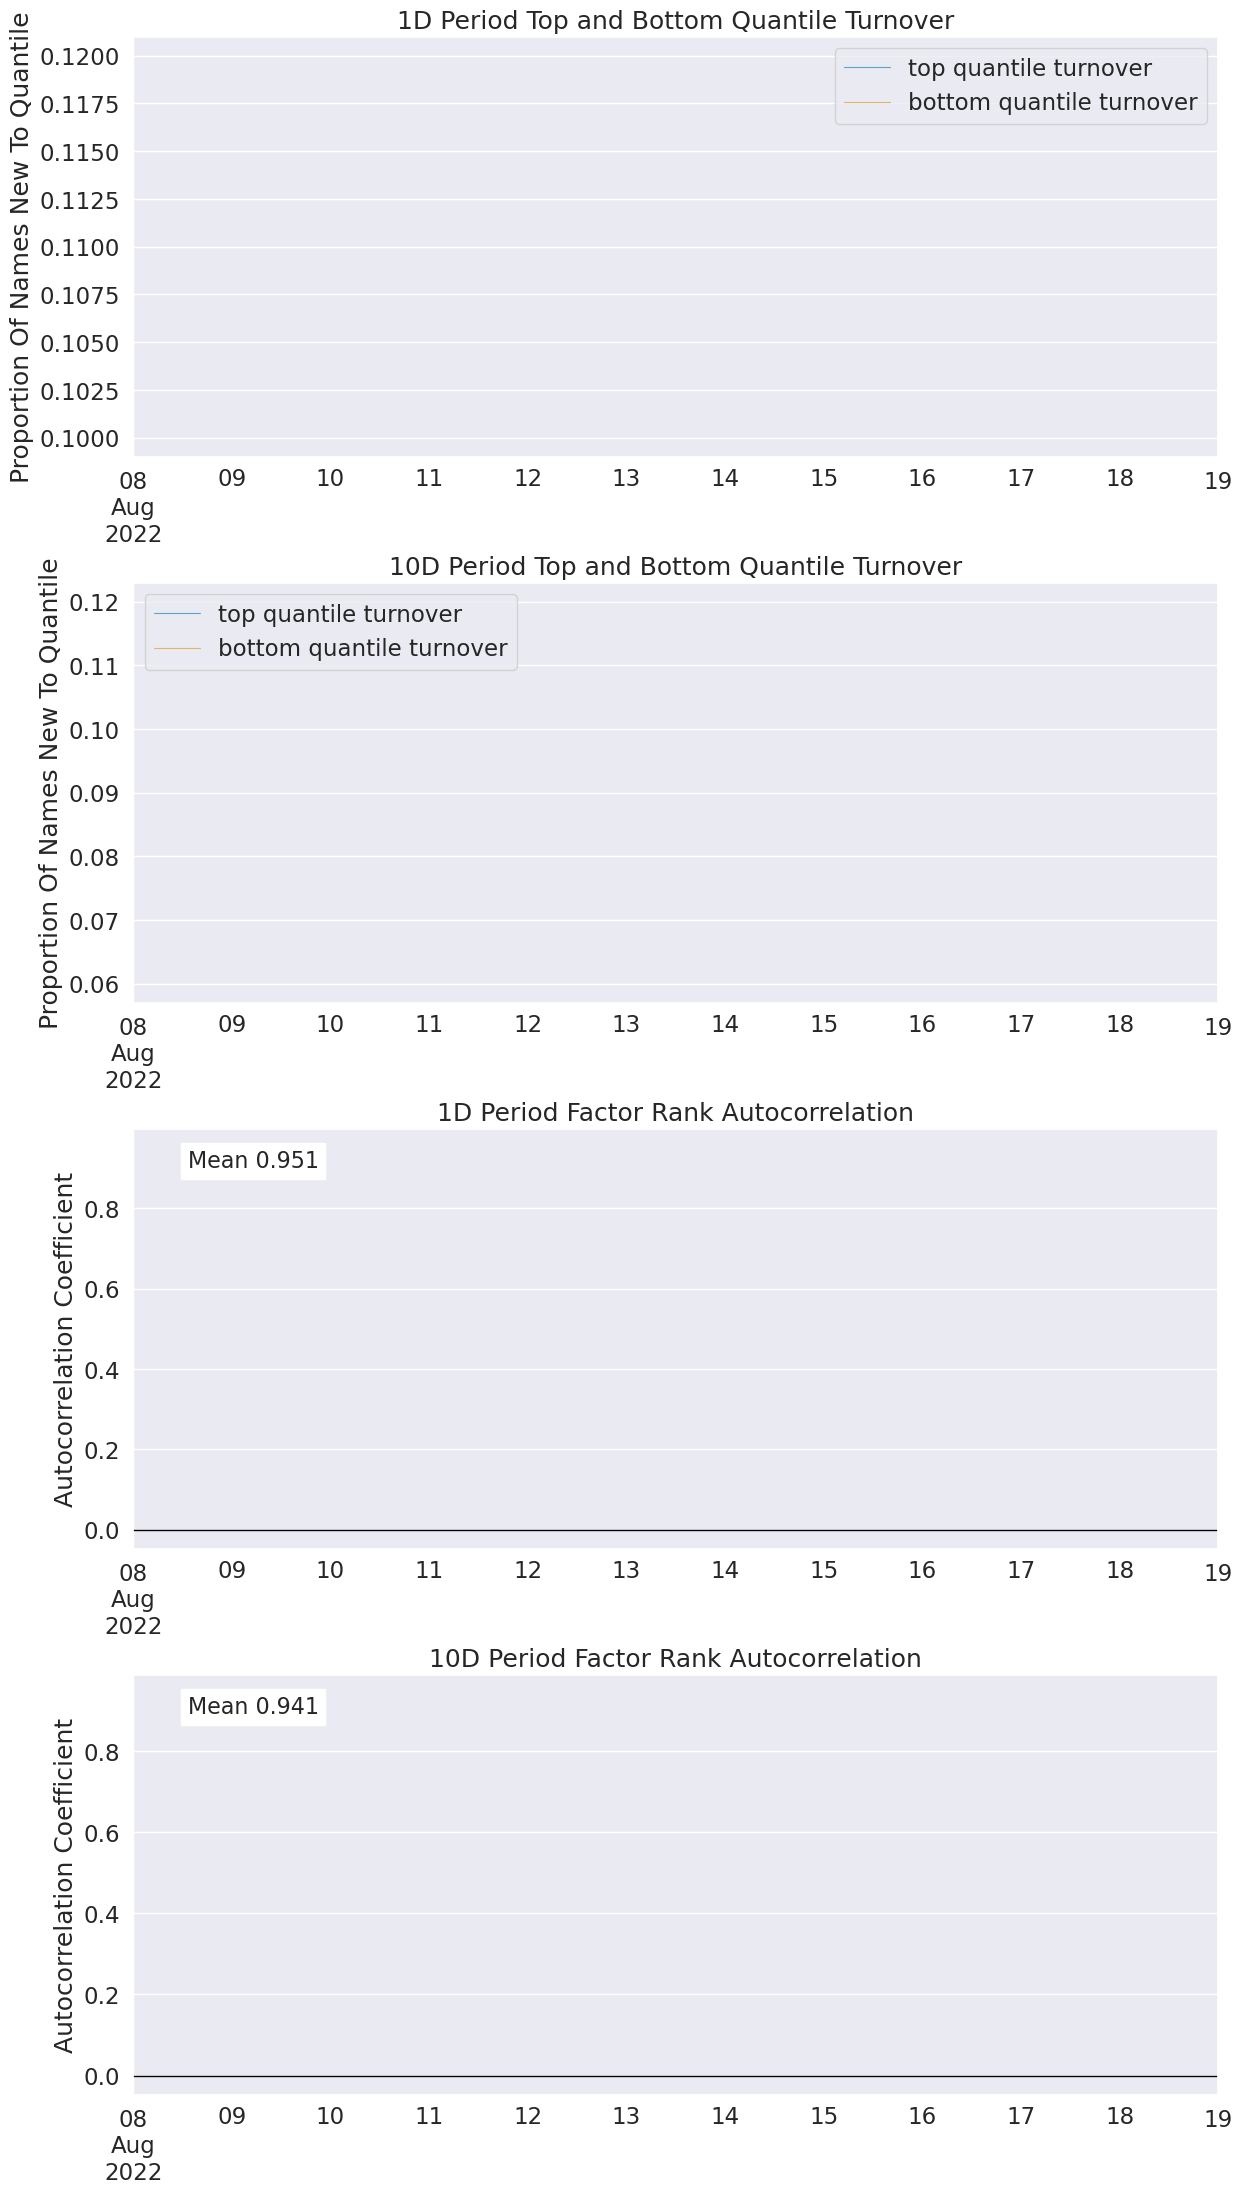

In [16]:
import pandas as pd
import alphalens as al

def generate_alphalens_tearsheet(df: pd.DataFrame, label_col: str, price_col: str) -> None:
    """
    Generate the Alphalens full tearsheet given the input dataframe, 
    label column, and price data column.
    """
    # Extract the factor and trade_prices series
    factor = df[label_col]
    trade_prices = df[price_col]
    
    # Remove duplicated indices from factor and trade_prices
    factor = factor[~factor.index.duplicated(keep='first')]
    trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
    # Convert the trade_prices series into unstacked format
    trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
    # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
    if isinstance(factor.index, pd.MultiIndex):
        level_0 = factor.index.get_level_values(0)
        if hasattr(level_0, 'tz') and level_0.tz is not None:
            if level_0.tz != trade_prices_unstacked.index.tz:
                factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), \
                    level=0, inplace=True)
        factor = factor.swaplevel().sort_index()
    else:
        if hasattr(factor.index, 'tz') and factor.index.tz is not None:
            if factor.index.tz != trade_prices_unstacked.index.tz:
                factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

    # Create the factor_data dataframe with forward returns
    alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
        factor=factor,
        prices=trade_prices_unstacked,
        periods=[1, 5, 10],
        max_loss=0.9
    )

    factor_returns = al.performance.factor_returns(alphalen_analysis)
    sharpe_ratios = factor_returns.mean() / factor_returns.std()

    print("\nSharpe Ratios:\n", sharpe_ratios)
    alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
    alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
    return alphalen_analysis

target = 'actual'
alphalens_analysis = generate_alphalens_tearsheet(preds, \
    label_col=target, price_col='FEATURE_close')

import alphalens as al
al.tears.create_full_tear_sheet(alphalens_analysis)

In [17]:
# import pandas as pd
# import alphalens as al

# def generate_alphalens_tearsheet(df: pd.DataFrame, \
#     label_col: str, price_col: str) -> None:
#     """
#     Generate the Alphalens full tearsheet given the input dataframe, 
#     label column, and price data column.
#     """
#     # Extract the factor and trade_prices series
#     factor = df[label_col]
#     trade_prices = df[price_col]
    
#     # Handle duplicate indices in trade_prices
#     trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
#     # Convert the trade_prices series into unstacked format
#     trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
#     # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
#     if isinstance(factor.index, pd.MultiIndex):
#         level_0 = factor.index.get_level_values(0)
#         if hasattr(level_0, 'tz') and level_0.tz is not None:
#             if level_0.tz != trade_prices_unstacked.index.tz:
#                 factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), level=0, inplace=True)
#         factor = factor.swaplevel().sort_index()
#     else:
#         if hasattr(factor.index, 'tz') and factor.index.tz is not None:
#             if factor.index.tz != trade_prices_unstacked.index.tz:
#                 factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

#     # Create the factor_data dataframe with forward returns
#     alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
#         factor=factor,
#         prices=trade_prices_unstacked,
#         periods=[1, 5, 10],
#         max_loss=0.5
#     )

#     factor_returns = al.performance.factor_returns(alphalen_analysis)
#     sharpe_ratios = factor_returns.mean() / factor_returns.std()

#     print("\nSharpe Ratios:\n", sharpe_ratios)
#     alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
#     alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
#     return alphalen_analysis

# target = 'predicted'
# alphalens_analysis = generate_alphalens_tearsheet(preds, label_col=target, price_col='FEATURE_close')

# import alphalens as al
# al.tears.create_full_tear_sheet(alphalens_analysis)

In [18]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [19]:
# Calculate the mean and standard deviation of daily correlations
mean_daily_correlation = daily_correlations.mean()
std_daily_correlation = daily_correlations.std()

# Calculate Sharpe ratio for each date
papermill_era_scores = daily_sharpe_ratios = (daily_correlations - \
    mean_daily_correlation) / std_daily_correlation

papermill_era_scores_df = papermill_era_scores.to_frame()
papermill_era_scores_df.columns = papermill_era_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_era_scores_df, display=True)

# papermill_era_scores_list = papermill_era_scores.tolist()
# sb.glue("papermill_era_scores", papermill_era_scores_list)


,0
date,
2022-08-05,0.885944
2022-08-08,0.013089
2022-08-09,0.666267
2022-08-10,0.597098
2022-08-11,0.938509
2022-08-12,1.143224
2022-08-15,1.284914
2022-08-16,0.881107
2022-08-17,0.798888


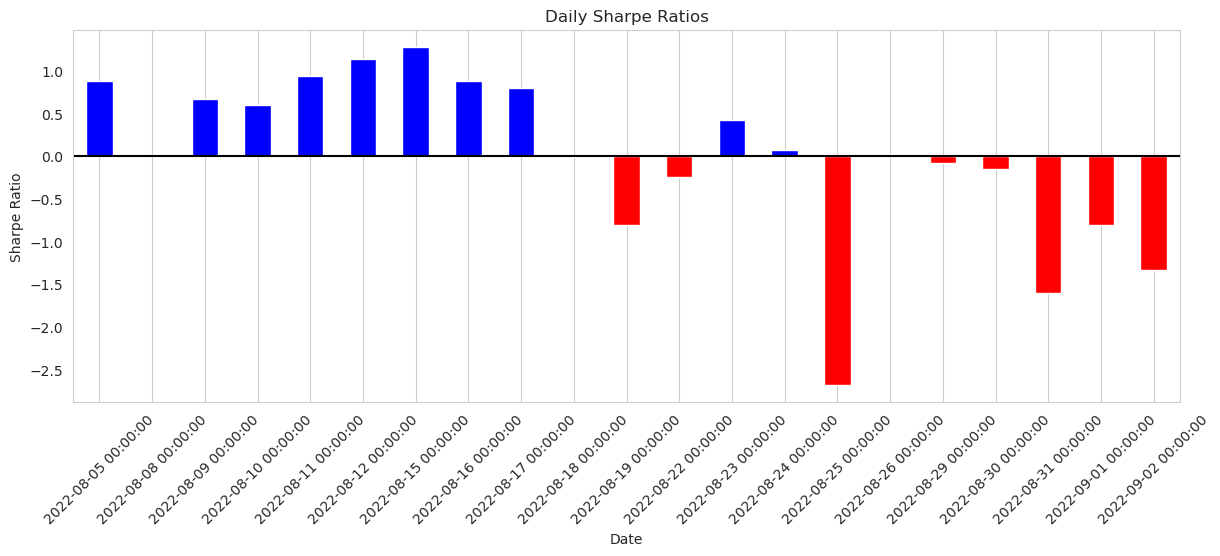

In [20]:
import matplotlib.pyplot as plt

# Create a list of colors based on the sign of the Sharpe Ratios
colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

plt.figure(figsize=(12,6))
daily_sharpe_ratios.plot(kind='bar', color=colors)
plt.title('Daily Sharpe Ratios')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.axhline(y=0, color='black', linestyle='-')  # Here's where we add the horizontal line at y=0
plt.xticks(rotation=45)  # rotates the x-axis labels for better visibility
plt.show()

In [21]:
plot_dir = Path("plots")
plot_dir.mkdir(exist_ok=True)
plot_path = plot_dir / f"sharpe_ratios_{key}.png"
plt.savefig(plot_path)
plt.close()

papermill_plot_path_str = str(plot_path)  # Convert to string
sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)  # Glue the string

'plots/sharpe_ratios_lambda_l2.png'

In [22]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 95.343% (p-value: 0.00000000%)


0.9534258505483174

0.0

In [23]:
# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str)  # Glue the string

# sb.glue("information_coefficient", information_coefficient)
# sb.glue("p_value", p_value)